## Importing Libraries and Loading the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('questions.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404351, 6)

## Data Analysis

In [5]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
371796,371796,727508,727509,How could I do better in physics?,How can I be better at physics?,1
230031,230031,453304,453305,"What is the perfect way to answer ""Tell me abo...","What should be ideal answer to the question ""T...",1
219450,219450,432639,432640,What is it like to be the AIIMS topper?,How can I be AIIMS topper?,0
232135,232135,457383,457384,What does the Bible say about incest?,Does the bible condone incest?,1
24983,24983,49834,49835,Can i not install windows 10 for free now?(Aft...,Why can't I install Windows 10?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.nunique()

id              404351
qid1            399334
qid2            397941
question1       290472
question2       299202
is_duplicate         2
dtype: int64

In [10]:
df['is_duplicate'].value_counts()

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

In [11]:
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

is_duplicate
0    63.07515
1    36.92485
Name: count, dtype: float64


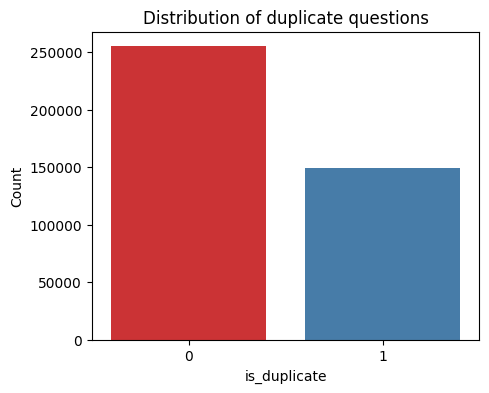

In [12]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['is_duplicate'].value_counts().index, y=df['is_duplicate'].value_counts(), palette='Set1')
plt.xlabel('is_duplicate')
plt.ylabel('Count')
plt.title('Distribution of duplicate questions')
plt.show()

In [13]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [14]:
# total number of unique question ids
print('Number of unique questions',np.unique(qid).shape[0])

Number of unique questions 789801


In [15]:
qid.duplicated().sum()

18901

In [16]:
x = qid.value_counts() > 1
print('Number of questions getting repeated',x[x].shape[0])

Number of questions getting repeated 13698


## Data Preprocessing

In [17]:
df.dropna(inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [18]:
# We take a smaller dataset for our purpose
new_df = df.sample(n=100000, random_state=2)
new_df=new_df.set_index('id')

In [19]:
new_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
302477,594007,594008,What are kalman filters used for?,What are examples of filters used in a home?,0
369857,723787,723788,How do Relationship work?,What matters in the life most dignity or money?,0
4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0
54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1
132567,262555,262556,Does Google Maps account for change in speed w...,What speed does Google Maps assume when it gen...,1


In [20]:
# To check new sample has same proportion
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)

is_duplicate
0    63.205
1    36.795
Name: count, dtype: float64


In [21]:
def replace_characters(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents.(e.g., 1000 → 1k, 1000000 → 1m).
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    return q

In [22]:
def remove_contractions(q):
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
        "'ve": " have",
        "n't": " not",
        "'re": " are",
        "'ll": " will"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word)

    q = ' '.join(q_decontracted)

    return q

In [23]:
# removing html tags
from bs4 import BeautifulSoup

def remove_html(q):
  q = BeautifulSoup(q)
  q = q.get_text()
  return q

In [24]:
# removing punctuation
def remove_punc(q):
  pattern = re.compile('\W')
  q = re.sub(pattern, ' ', q).strip()
  return q

In [25]:
# removing URLs
def remove_url(q):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r' ', q)

In [26]:
def process_text(text):
    text = replace_characters(text)
    text = remove_contractions(text)
    text = remove_html(text)
    text = remove_punc(text)
    text = remove_url(text)
    return text

In [27]:
new_df['question1'] = new_df['question1'].apply(process_text)
new_df['question2'] = new_df['question2'].apply(process_text)

In [28]:
new_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
302477,594007,594008,what are kalman filters used for,what are examples of filters used in a home,0
369857,723787,723788,how do relationship work,what matters in the life most dignity or money,0
4665,9325,9326,how would an arbitrageur seek to capitalize gi...,how would an arbitrageur seek to capitalize gi...,0
54203,107861,107862,why did quora mark my question as incomplete,why does quora detect my question as an incomp...,1
132567,262555,262556,does google maps account for change in speed w...,what speed does google maps assume when it gen...,1


In [29]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_sw(text):
  new_text=[]

  for word in text.split():
    if word in stopwords.words('english'):
      new_text.append("")
    else:
      new_text.append(word)

  return " ".join(new_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deepu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
new_df['question1'] = new_df['question1'].apply(remove_sw)
new_df['question2'] = new_df['question2'].apply(remove_sw)

In [31]:
#Lemmatization

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags for lemmatization
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to perform lemmatization on a text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deepu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\deepu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deepu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# Apply lemmatization to the columns
new_df['question1_lemmatized'] = new_df['question1'].apply(lemmatize_text)
new_df['question2_lemmatized'] = new_df['question2'].apply(lemmatize_text)

## Feature Engineering

In [33]:
# Length of q1 and q2
new_df['q1_len'] = new_df['question1_lemmatized'].str.len()
new_df['q2_len'] = new_df['question2_lemmatized'].str.len()

In [34]:
# No. of words in q1 and q2
new_df['q1_num_words'] = new_df['question1_lemmatized'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] =new_df['question2_lemmatized'].apply(lambda row: len(row.split(" ")))
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words
id,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,4
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,4
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,17
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,5
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,9


In [35]:
# No. of Common_words in q1 and q2
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1_lemmatized'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2_lemmatized'].split(" ")))
    return len(w1 & w2)

new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common
id,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,4,2
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,4,0
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,17,13
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,5,3
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,9,5


In [36]:
# Total no. of words in q1 + q2
new_df['word_total'] = new_df["q1_num_words"]+new_df["q2_num_words"]
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
id,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,4,2,7
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,4,0,6
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,17,13,34
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,5,3,9
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,9,5,17


In [37]:
# ratio of word_common to word_total
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
id,,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,4,2,7,0.29
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,4,0,6,0.00
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,17,13,34,0.38
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,5,3,9,0.33
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,9,5,17,0.29


In [38]:
# jaccard similarty
def jaccard_similarity(q1, q2):
    w1 = set(q1.split())
    w2 = set(q2.split())
    intersection = w1.intersection(w2)
    union = w1.union(w2)
    return float(len(intersection)) / max(len(union), 1)

new_df['jacc_similarity'] = new_df.apply(lambda row: jaccard_similarity(row['question1_lemmatized'], row['question2_lemmatized']), axis=1)

In [39]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1_lemmatized']
    q2 = row['question2_lemmatized']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [40]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [41]:
print(new_df.shape)
new_df.head()

(100000, 19)


,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,jacc_similarity,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
id,,,,,,,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,4,2,7,0.29,0.400000,65,76,60,74
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,4,0,6,0.00,0.000000,24,29,24,24
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,17,13,34,0.38,1.000000,100,100,100,100
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,5,3,9,0.33,0.500000,73,80,70,91
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,9,5,17,0.29,0.416667,58,62,67,75


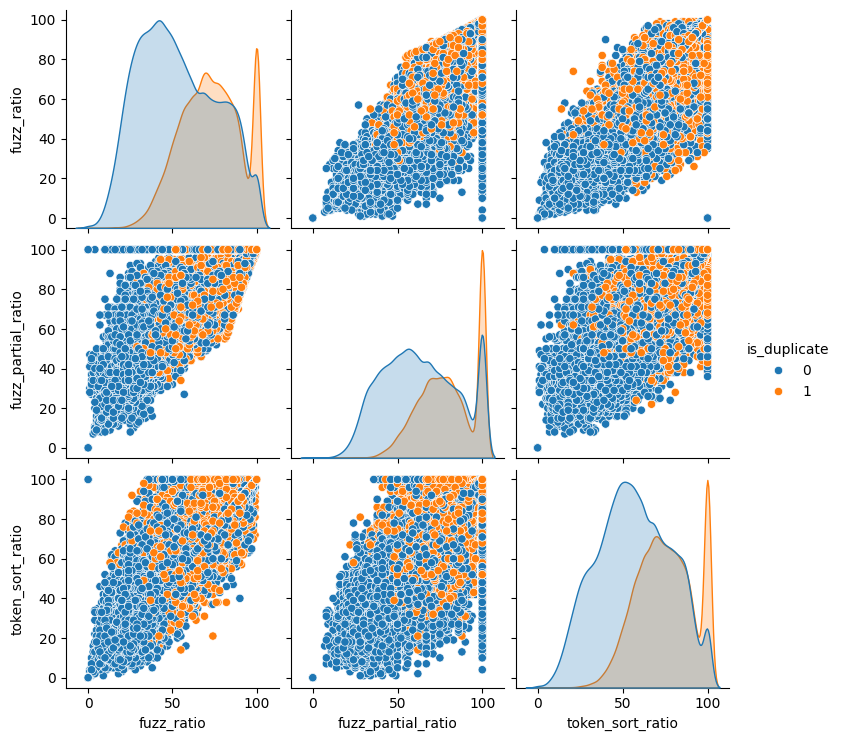

In [42]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio','is_duplicate']],hue='is_duplicate')

In [43]:
# Check first word and last word similarity
new_df['first_word_same'] = (new_df['question1_lemmatized'].str.split().str[0] == new_df['question2_lemmatized'].str.split().str[0]).astype(int)
new_df['last_word_same'] = (new_df['question1_lemmatized'].str.split().str[-1] == new_df['question2_lemmatized'].str.split().str[-1]).astype(int)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,...,word_common,word_total,word_share,jacc_similarity,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,first_word_same,last_word_same
id,,,,,,,,,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,...,2,7,0.29,0.400000,65,76,60,74,0,0
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,...,0,6,0.00,0.000000,24,29,24,24,0,0
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,...,13,34,0.38,1.000000,100,100,100,100,1,1
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,...,3,9,0.33,0.500000,73,80,70,91,1,0
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,...,5,17,0.29,0.416667,58,62,67,75,0,0


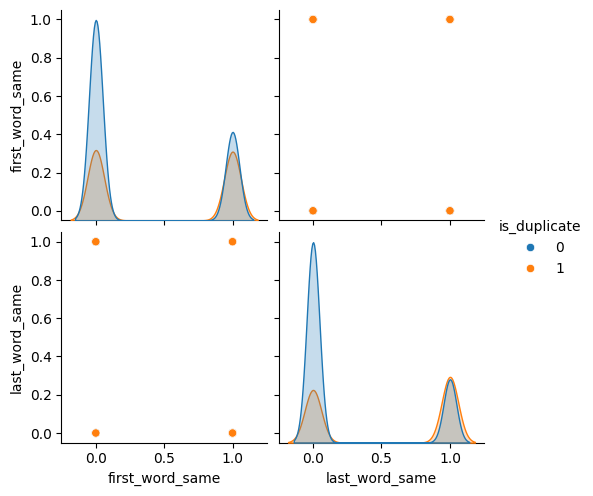

In [44]:
sns.pairplot(new_df[['first_word_same', 'last_word_same', 'is_duplicate']],hue='is_duplicate')

## Creating Word Embeddings

In [45]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [46]:
# Tokenize the text in each column
q1_token = new_df['question1_lemmatized'].apply(word_tokenize)
q2_token = new_df['question2_lemmatized'].apply(word_tokenize)

In [47]:
sentences = q1_token.tolist() + q2_token.tolist()

In [48]:
sentences[0]

['kalman', 'filter', 'use']

In [49]:
model = Word2Vec(sentences,
                 vector_size=150,      #Dimensionality of the word vectors
                 window=5,             # Maximum distance between the current and predicted word within a sentence.
                 min_count=1,          #Ignores all words with a total frequency lower than this.
                 sg=0)                 #sg=0 uses CBOW, sg=1 uses skip-gram.

In [50]:
def get_sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

In [51]:
q1_vector = q1_token.apply(lambda x: get_sentence_vector(x, model))
q2_vector = q2_token.apply(lambda x: get_sentence_vector(x, model))

In [52]:
new_df['q1_vector']=q1_vector
new_df['q2_vector']=q2_vector
new_df.head(5)

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,...,word_share,jacc_similarity,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,first_word_same,last_word_same,q1_vector,q2_vector
id,,,,,,,,,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,...,0.29,0.400000,65,76,60,74,0,0,"[0.16337447, -0.26458463, -0.10362225, 0.16659...","[-0.13340703, -0.43139863, -0.2745417, 0.00221..."
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,...,0.00,0.000000,24,29,24,24,0,0,"[0.36159208, 0.3791927, -1.1463468, 0.8113533,...","[-0.07099732, -0.35407773, -1.2412971, 0.29941..."
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,...,0.38,1.000000,100,100,100,100,1,1,"[0.58242625, 0.02053596, -0.06837075, -0.08586...","[0.58242625, 0.02053596, -0.06837075, -0.08586..."
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,...,0.33,0.500000,73,80,70,91,1,0,"[1.2815787, -0.36062345, -0.34315017, -0.04039...","[0.6479157, -0.34694928, -0.22909288, 0.070495..."
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,...,0.29,0.416667,58,62,67,75,0,0,"[0.77456754, -0.27508855, -0.5289612, -0.13772...","[0.3661733, -0.09613374, -0.25137842, -0.32360..."


In [53]:
# Determine the length of the vectors
vector1_length = len(new_df['q1_vector'].iloc[0])
vector2_length = len(new_df['q2_vector'].iloc[0])

# Create new columns for each element in the vector
for i in range(vector1_length):
    new_df[f'question1_vector_{i}'] = new_df['q1_vector'].apply(lambda x: x[i])

for i in range(vector2_length):
    new_df[f'question2_vector_{i}'] = new_df['q2_vector'].apply(lambda x: x[i])

new_df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,...,question2_vector_140,question2_vector_141,question2_vector_142,question2_vector_143,question2_vector_144,question2_vector_145,question2_vector_146,question2_vector_147,question2_vector_148,question2_vector_149
id,,,,,,,,,,,,,,,,,,,,,
302477,594007,594008,kalman filters used,examples filters used home,0,kalman filter use,example filter use home,17,23,3,...,0.249378,-0.031769,0.091285,0.157953,0.524574,-0.049045,-0.406387,-0.178967,0.245398,-0.581483
369857,723787,723788,relationship work,matters life dignity money,0,relationship work,matter life dignity money,17,25,2,...,0.213165,0.834987,0.970896,0.425058,0.821440,0.405867,0.241130,-0.090890,0.215295,0.171148
4665,9325,9326,would arbitrageur seek capitalize given fo...,would arbitrageur seek capitalize given fo...,0,would arbitrageur seek capitalize give follow ...,would arbitrageur seek capitalize give follow ...,80,80,17,...,0.266235,0.114145,0.336534,0.013690,0.587741,0.425666,-0.458973,0.032508,0.339470,-0.094680
54203,107861,107862,quora mark question incomplete,quora detect question incomplete sentence,1,quora mark question incomplete,quora detect question incomplete sentence,30,41,4,...,0.394075,0.492873,0.722477,-0.169897,0.479403,0.688883,-0.196349,-0.949122,0.811426,-0.726923
132567,262555,262556,google maps account change speed estimatin...,speed google maps assume generates estimat...,1,google map account change speed estimate trip ...,speed google map assume generates estimate tim...,50,57,8,...,0.320122,0.389311,0.323295,0.369039,0.199746,0.498563,-0.298145,-0.387688,0.546150,-0.009630


In [54]:
new_df.shape

(100000, 323)

In [55]:
q1_vector.iloc[0]

array([ 0.16337447, -0.26458463, -0.10362225,  0.1665933 ,  0.28832808,
        0.05820792, -0.31943616,  0.49397957, -0.09279338,  0.00486558,
        0.00533027,  0.06467225, -0.24638183,  0.00568342, -0.33207154,
       -0.10338715, -0.4000027 , -0.6215247 ,  0.31388906, -0.22284181,
       -0.3445387 ,  0.1346927 ,  0.12749253,  0.575815  ,  0.19071062,
        0.10306881, -0.10205358, -0.7252999 ,  0.06248086, -0.21337563,
        0.01838963,  0.28145328,  0.0021337 ,  0.4397939 , -0.15622091,
       -0.03738305,  0.03283801,  0.08562657,  0.11446632, -0.17310263,
        0.26958147, -0.08538195,  0.04848105,  0.01683287, -0.20898555,
        0.17821081,  0.46346548, -0.13777108, -0.30331644, -0.00735367,
        0.02980631,  0.57680506, -0.32278478,  0.16154115,  0.04861094,
        0.27481782, -0.39788985,  0.62105817, -0.46459162,  0.01634309,
       -0.30278778, -0.28747752, -0.10219868,  0.13495806,  0.41532028,
       -0.58784765,  0.16480507, -0.41118753, -0.39316145, -0.09

In [56]:
# cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

cosine_similarity(q1_vector.iloc[0],q2_vector.iloc[0])

0.8998639

In [57]:
new_df['cos_similarity'] = new_df.apply(lambda row: cosine_similarity(row['q1_vector'], row['q2_vector']), axis=1)
new_df['cos_similarity']

id
302477    0.899864
369857    0.566552
4665      1.000000
54203     0.934315
132567    0.910127
            ...   
351167    0.977247
214930    0.829380
322756    0.737266
208941    0.920862
179552    0.991554
Name: cos_similarity, Length: 100000, dtype: float64

In [58]:
# distance-based similarty (euclidean)
from scipy.spatial.distance import euclidean, cityblock
new_df['euclidean_distance'] = new_df.apply(lambda x: euclidean(x['q1_vector'], x['q2_vector']), axis=1)

In [59]:
new_df.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_lemmatized', 'question2_lemmatized', 'q1_len', 'q2_len',
       'q1_num_words',
       ...
       'question2_vector_142', 'question2_vector_143', 'question2_vector_144',
       'question2_vector_145', 'question2_vector_146', 'question2_vector_147',
       'question2_vector_148', 'question2_vector_149', 'cos_similarity',
       'euclidean_distance'],
      dtype='object', length=325)

In [60]:
final_df=new_df.drop(['qid1', 'qid2', 'question1', 'question2',
       'question1_lemmatized', 'question2_lemmatized','q1_vector','q2_vector'],axis=1)

In [61]:
final_df.shape

(100000, 317)

## Evaluating the model

In [62]:
final_df.head(5)

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,jacc_similarity,fuzz_ratio,...,question2_vector_142,question2_vector_143,question2_vector_144,question2_vector_145,question2_vector_146,question2_vector_147,question2_vector_148,question2_vector_149,cos_similarity,euclidean_distance
id,,,,,,,,,,,,,,,,,,,,,
302477,0,17,23,3,4,2,7,0.29,0.400000,65,...,0.091285,0.157953,0.524574,-0.049045,-0.406387,-0.178967,0.245398,-0.581483,0.899864,2.019977
369857,0,17,25,2,4,0,6,0.00,0.000000,24,...,0.970896,0.425058,0.821440,0.405867,0.241130,-0.090890,0.215295,0.171148,0.566552,6.266243
4665,0,80,80,17,17,13,34,0.38,1.000000,100,...,0.336534,0.013690,0.587741,0.425666,-0.458973,0.032508,0.339470,-0.094680,1.000000,0.000000
54203,1,30,41,4,5,3,9,0.33,0.500000,73,...,0.722477,-0.169897,0.479403,0.688883,-0.196349,-0.949122,0.811426,-0.726923,0.934315,3.199476
132567,1,50,57,8,9,5,17,0.29,0.416667,58,...,0.323295,0.369039,0.199746,0.498563,-0.298145,-0.387688,0.546150,-0.009630,0.910127,2.488186


In [63]:
df_final=final_df.dropna()

In [64]:
X=df_final.drop(['is_duplicate'],axis=1)
y=df_final['is_duplicate']

In [65]:
X.shape,y.shape

((99960, 316), (99960,))

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Building an ANN model

In [68]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

model=Sequential()
model.add(Dense(units=256,kernel_initializer = 'uniform',input_dim=316,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [69]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [70]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        81,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,745 (530.25 KB)

 Trainable params: 135,233 (528.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [71]:
history = model.fit(X_train_scaled,y_train,batch_size=32,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7170 - loss: 0.5267 - val_accuracy: 0.7596 - val_loss: 0.4599
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7589 - loss: 0.4670 - val_accuracy: 0.7692 - val_loss: 0.4501
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7639 - loss: 0.4565 - val_accuracy: 0.7668 - val_loss: 0.4498
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7677 - loss: 0.4508 - val_accuracy: 0.7755 - val_loss: 0.4377
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7771 - loss: 0.4399 - val_accuracy: 0.7789 - val_loss: 0.4395
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7817 - loss: 0.4341 - val_accuracy: 0.7804 - val_loss: 0.4323
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7849 - loss: 0.4275 - val_accuracy: 0.7850 - val_loss: 0.4245
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7887 - loss: 0

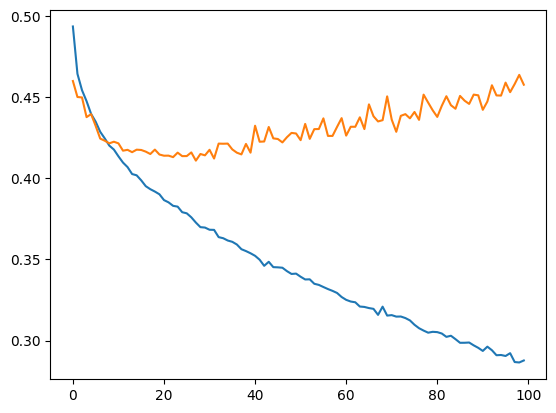

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

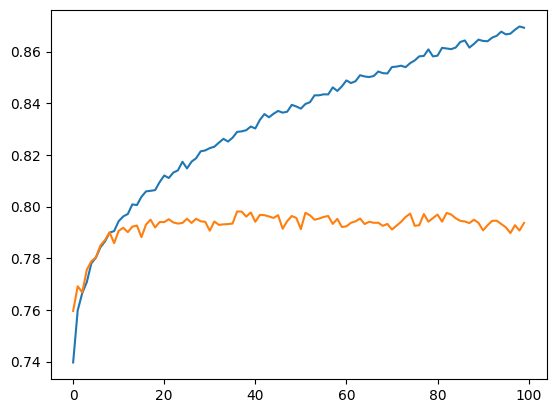

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [74]:
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)    # Convert probabilities to 0 or 1

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [75]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Precision: 0.7311946902654868
Recall: 0.7086571964620745
F1 Score: 0.7197495576425752


In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[10586,  1944],
       [ 2174,  5288]], dtype=int64)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


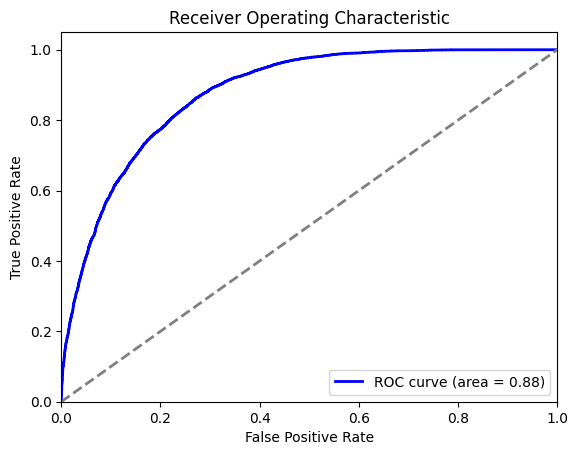

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc # Import auc

# Use predict to get probabilities, then extract for class 1
y_prob = model.predict(X_test_scaled)[:, 0]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)  # Use auc function here

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [78]:
# Save Keras model
model.save('model.h5')  # HDF5 format